In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Trainig data

In [3]:
normalized_scan_100206 = np.load('normalised_data/normalized_scan_100206.npy')

In [4]:
normalized_scan_100206.shape

(935442, 288)

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [3]:
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [4]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [5]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [6]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [7]:
len(indices_beginning_0_all)

2234299

In [8]:
mask_0 = np.where(mask_100206_long[:,0] == 0)[0]

In [9]:
len(mask_0)

2722094

In [10]:
mask_100206_long_pro = np.copy(mask_100206_long)

In [11]:
mask_100206_long_pro[indices_beginning_0_all] = 0

In [12]:
mask_0_pro = np.where(mask_100206_long_pro[:,0] == 0)[0]
print(len(mask_0_pro))

2722908


In [14]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [9]:
bvals = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

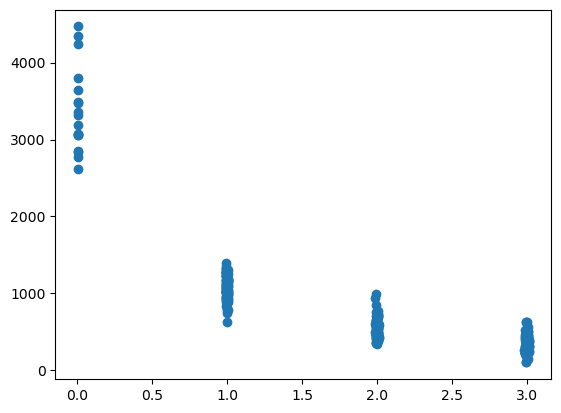

In [52]:
plt.plot(bvals, scan_100206_long_no_background[1400,:], "o")

In [28]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals)

In [29]:
S0_100206.shape

(935442, 1)

In [30]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [71]:
len(normalized_scan_100206)

935442

In [44]:
np.save('normalized_scan_100206.npy', normalized_scan_100206)

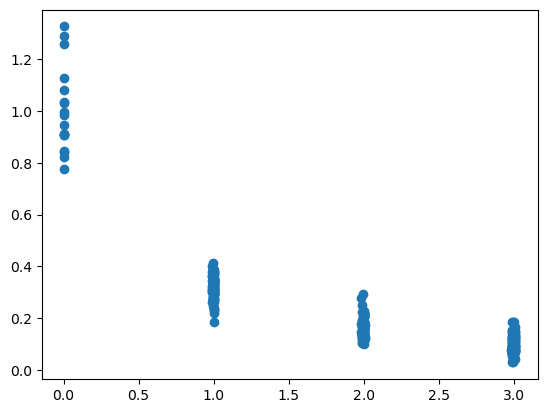

In [53]:
plt.plot(bvals, normalized_scan_100206[1400,:], "o")

## Neural Network

In [5]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [6]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [7]:
def get_acquisition_scheme():
    bvals = np.loadtxt(
        config.data_folder2 + '/100206/bvals'
    ) * 1e-3
    # s/m^2
    gradient_directions = np.loadtxt(
        config.data_folder2 + '/100206/bvecs'
    ).T

    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [8]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        # theta = squash(theta_uns, 0, np.pi)
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        # phi = squash(phi_uns, -np.pi, np.pi)
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        # s0 = params[:, 5].unsqueeze(1)
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [10]:
n = np.loadtxt(config.data_folder2 + '/100206/bvecs').T
b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [12]:
batch_size = 128
num_batches = len(normalized_scan_100206) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206.astype(np.float32)),
                               batch_size = batch_size, 
                               shuffle = True,
                               num_workers = 2,
                               drop_last = True)

In [13]:
loss_arr=[]
avg_loss_arr=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred,  volume_0_pred, volume_1_pred = net(X_batch)
        if i == 8 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    avg_loss_arr.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.74it/s]


Loss: 429.49138434045017
Average Loss: 0.05877003069792695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.55it/s]


Loss: 409.7990616885945
Average Loss: 0.056075405266638546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.37it/s]


Loss: 407.4123647729866
Average Loss: 0.055748818387108184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.77it/s]


Loss: 410.8456605435349
Average Loss: 0.05621861802730363
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.35it/s]


Loss: 417.62258263817057
Average Loss: 0.05714594726849625
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 114.18it/s]


Loss: 404.927589523606
Average Loss: 0.05540881082698495
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.46it/s]


Loss: 401.88656350038946
Average Loss: 0.05499268794477141
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.26it/s]


Loss: 399.1033266365994
Average Loss: 0.05461183998858776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.02it/s]


Loss: 394.19015565607697
Average Loss: 0.05393953963547851
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.64it/s]


Loss: 393.68515168107115
Average Loss: 0.05387043673796814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  0%|▏                                                           | 24/7308 [00:03<09:10, 13.24it/s]

X_batch: 
torch.Size([128, 288])
tensor([[1.0487, 0.5614, 0.1955,  ..., 0.4338, 0.2653, 0.2234],
        [1.0632, 0.5064, 0.2432,  ..., 0.5462, 0.2655, 0.1486],
        [0.9897, 0.2747, 0.5533,  ..., 0.4617, 0.3824, 0.6936],
        ...,
        [1.0633, 0.5875, 0.2441,  ..., 0.5495, 0.3201, 0.1178],
        [1.0025, 0.4974, 0.4042,  ..., 0.5184, 0.3160, 0.4463],
        [1.0576, 0.3920, 0.2028,  ..., 0.3967, 0.2437, 0.1920]])
X_pred: 
torch.Size([128, 288])
tensor([[0.9957, 0.4807, 0.2451,  ..., 0.4736, 0.2886, 0.2045],
        [0.9959, 0.4851, 0.2662,  ..., 0.4828, 0.2876, 0.1899],
        [0.9946, 0.4620, 0.5085,  ..., 0.5470, 0.4156, 0.6881],
        ...,
        [0.9962, 0.4997, 0.2528,  ..., 0.4938, 0.2818, 0.1685],
        [0.9960, 0.5694, 0.3350,  ..., 0.5099, 0.3922, 0.3404],
        [0.9948, 0.4124, 0.2206,  ..., 0.4034, 0.2455, 0.1860]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.33it/s]


Loss: 393.8564304616302
Average Loss: 0.05389387390005887
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.70it/s]


Loss: 392.02418186329305
Average Loss: 0.053643155701052686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.47it/s]


Loss: 391.2469421061687
Average Loss: 0.053536801054483954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.86it/s]


Loss: 404.60194718372077
Average Loss: 0.05536425111983043
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:35<00:00, 76.83it/s]


Loss: 419.2334280379582
Average Loss: 0.057366369463322145
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.27it/s]


Loss: 412.1365262349136
Average Loss: 0.05639525536876212
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.45it/s]


Loss: 405.48529457161203
Average Loss: 0.05548512514663547
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 121.99it/s]


Loss: 470.00331048481166
Average Loss: 0.06431353454909848
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.85it/s]


Loss: 468.77500478504226
Average Loss: 0.06414545768815576
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.59it/s]


Loss: 456.1201668183785
Average Loss: 0.06241381593026526
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.77it/s]


Loss: 463.3221077697817
Average Loss: 0.06339930319783549
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.55it/s]


Loss: 452.9228739743121
Average Loss: 0.06197631006763986
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.81it/s]

Loss: 457.46210233075544
Average Loss: 0.06259744147930425
Done, best loss: 391.2469421061687
Done


<All keys matched successfully>

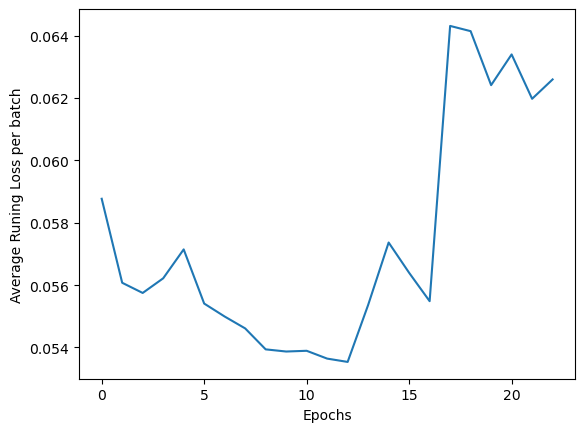

In [14]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [15]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=5, bias=True)
  )
)

In [16]:
torch.save(final_model, 'model_100206_not_converge.pt')

In [17]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_100206.astype(np.float32)))

In [18]:
X_pred_train.shape

torch.Size([935442, 288])

In [60]:
# Load model

# net_test = BallStickNet(gradient_directions, b_values)
# net_test.load_state_dict(torch.load('model_100206_61e.pt'))
# net_test.eval()
# X_pred_test, mu_cart_pred_test, lambda_par_pred_test, lambda_iso_pred_test,  volume_0_pred_test, volume_1_pred_test, s0_pred_test = net_test(torch.from_numpy(normalized_scan_100206.astype(np.float32)))

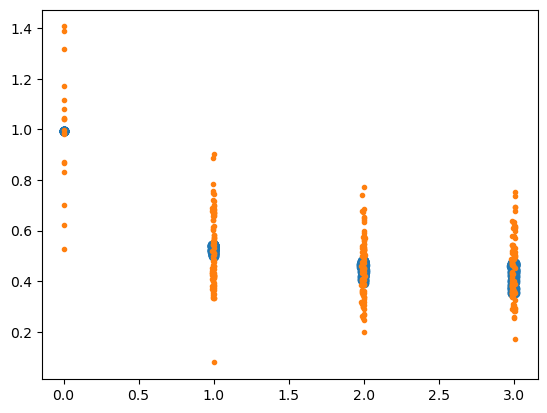

In [19]:
plt.plot(bvals, X_pred_train[1,:].detach().numpy(),  "o")
# plt.plot(X_pred_train[110,:].detach().numpy())
plt.plot(bvals,normalized_scan_100206[1,:], ".")

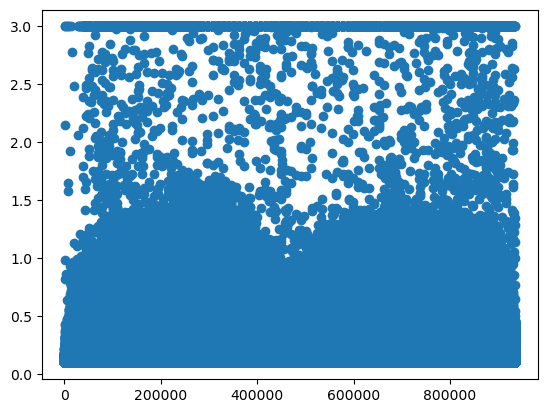

In [20]:
plt.plot(lambda_par_pred_train.detach().numpy(), 'o')

In [21]:
torch.min(lambda_par_pred_train)

tensor(0.1000, grad_fn=<MinBackward1>)

In [22]:
torch.max(lambda_par_pred_train)

tensor(3., grad_fn=<MaxBackward1>)

## Parameter maps

In [105]:
print(X_pred_train.shape)
print(normalized_scan_100206.shape)

torch.Size([935442, 288])
(935442, 288)


In [108]:
lambda_par_pred_train.shape

torch.Size([935442, 1])

In [127]:
mask_100206_long_pro.shape

(3658350, 1)

In [111]:
scan_100206_long.shape

(3658350, 288)

In [115]:
bg_indices = np.where(mask_100206_long_pro == 0)[0]

In [121]:
lambda_par_pred_train_cp = np.copy(lambda_par_pred_train.detach().numpy())

In [ ]:
def replace_ones(mask_100206, params):
    mask_100206_cp = np.copy(mask_100206)
    bg_indices = np.where(mask_100206_cp == 1)[0]
    for i, index in enumerate(bg_indices):
        mask_100206_cp[index] = params[i]
    return mask_100206_cp